In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader , Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

import nevergrad as ng

import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import copy

In [2]:
data = pd.read_csv("winequality-red.csv", sep=";")
data_train, data_test = train_test_split(data, test_size=0.25)
# normalize data
scaler = MinMaxScaler()
columns_to_normalize = data_train.columns.tolist()
data_train[columns_to_normalize] = scaler.fit_transform(data_train[columns_to_normalize])
data_test[columns_to_normalize] = scaler.transform(data_test[columns_to_normalize])

FileNotFoundError: [Errno 2] No such file or directory: 'winequality-red.csv'

In [162]:
# create model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(11, 10).to(dtype=torch.float64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, 1).to(dtype=torch.float64)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [1]:
class train_manager:
    def __init__(self,model,dataloader_train,dataloader_test,loss,output):
        self.model = model
        self.best_model = None
        self.dataloader_train = dataloader_train
        self.dataloader_test = dataloader_test
        self.nb_batch = len(dataloader_train)
        self.best_score = 1e9
        self.loss = loss
        self.iteration = 0
        self.output = output
        self.best_output = output
        self.best_accuracy = 0
    
    def weights_updating(self,weights):
        for n, layer in enumerate(self.model.parameters()):
            layer.data = torch.from_numpy(weights[n]).to(dtype=torch.float64)
            
    def evaluate(self):
        correct = 0
        total_loss = 0
        for x , y in self.dataloader_test :
            yhat = self.model(x)
            correct += (torch.abs(yhat-y)<0.5).type(torch.float).sum().item() # Compute classification error
            loss = self.loss(yhat,y)
            total_loss += loss.item()
        correct /= len(self.dataloader_test.dataset)
        total_loss /= len(self.dataloader_test)
        return total_loss,correct
    
    def cost_function(self,input_weight , first_hidden_weight , second_hidden_weight, output_weight):
        
        weights = [input_weight , first_hidden_weight , second_hidden_weight, output_weight]
        self.weights_updating(weights)

        test_loss,accuracy = self.evaluate()
        if self.best_score > test_loss :
            self.best_score = test_loss
            #self.best_model = copy.deepcopy(self.model)
        if self.best_accuracy < accuracy :
            self.best_accuracy = accuracy
            self.best_model = copy.deepcopy(self.model)
        print(f'test loss function (mse) : {test_loss}, precision : {(100*accuracy):>0.1f}% , best score : {self.best_score}')
        self.output[self.iteration,:] = np.array([test_loss,accuracy])
        self.best_output[self.iteration,:] = np.array([self.best_score,self.best_accuracy])
        self.iteration += 1
        return -accuracy #test_loss

In [2]:
class create_dataset(Dataset):
    def __init__(self, data,):
        self.data = data
        
    def __getitem__(self, index):
        x = torch.from_numpy(self.data.iloc[index][:-1].to_numpy())
        y = torch.from_numpy(self.data.iloc[index][-1:].to_numpy())
        return x, y
    
    def __len__(self):
        return len(self.data)

dataset_train = create_dataset(data_train)   #sans passer par ca, aucun problème pour le dataloader mais derrière la fonction d'optimiation de nevergrad marche pas 
dataset_test  = create_dataset(data_test)

training_loader = DataLoader(dataset_train, batch_size=128, shuffle=True)
validation_loader = DataLoader(dataset_test, batch_size=1, shuffle=True)

NameError: name 'Dataset' is not defined

In [171]:
model = Net()
model = model.to(dtype=torch.float64)
loss = nn.MSELoss().to(dtype=torch.float64)

In [172]:
parameters = []
for _, param in model.named_parameters():
    parameters.append(torch.Tensor.numpy(param.data))

#pour l'instant a adapter selon le nombre de couches
parametrization = ng.p.Instrumentation(
    input_weight=ng.p.Array(shape = np.shape(parameters[0])),
    first_hidden_weight=ng.p.Array(shape = np.shape(parameters[1])),
    second_hidden_weight=ng.p.Array(shape = np.shape(parameters[2])),
    output_weight=ng.p.Array(shape = np.shape(parameters[3]))
)

epochs = 50
output = np.empty((epochs,2))
trainer = train_manager(model,training_loader,validation_loader,loss,output)
fitness = trainer.cost_function
optimizer = ng.optimizers.NGOpt(parametrization=parametrization, budget=epochs)
learned_param = optimizer.minimize(fitness)
output = trainer.output             #output of epoch n°i
best_output = trainer.best_output   #best output after i epochs
plotloss = best_output[:,0].copy()
plotaccuracy = best_output[:,1].copy()

test loss function (mse) : 0.2919999999999988, precision : 49.8% , best score : 0.2919999999999988
test loss function (mse) : 38.428300293957676, precision : 5.5% , best score : 0.2919999999999988
test loss function (mse) : 3.899920986133858, precision : 13.0% , best score : 0.2919999999999988
test loss function (mse) : 2.6473542083243005, precision : 15.5% , best score : 0.2919999999999988
test loss function (mse) : 33.59810956287737, precision : 0.0% , best score : 0.2919999999999988
test loss function (mse) : 11.33192370603049, precision : 0.0% , best score : 0.2919999999999988
test loss function (mse) : 4.763951233089787, precision : 0.2% , best score : 0.2919999999999988
test loss function (mse) : 0.31434375399346176, precision : 67.8% , best score : 0.2919999999999988
test loss function (mse) : 51.85269608997705, precision : 0.2% , best score : 0.2919999999999988
test loss function (mse) : 13.58200441521544, precision : 13.2% , best score : 0.2919999999999988
test loss function (

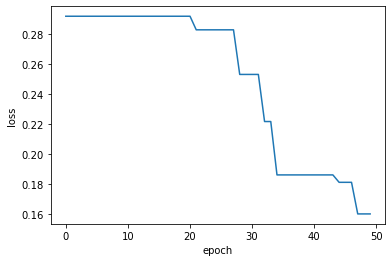

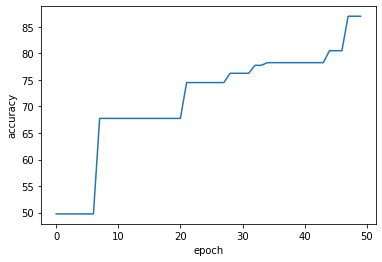

In [173]:
plt.plot([i for i in range(len(plotloss))],plotloss)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.plot([i for i in range(len(plotaccuracy))],plotaccuracy*100)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

Test 2

In [191]:
data=pd.read_csv("ex3_train.csv",index_col=None)

In [186]:
# create model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(81, 10).to(dtype=torch.float64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, 1).to(dtype=torch.float64)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

class create_dataset(Dataset):
    def __init__(self, data,):
        self.data = data
        
    def __getitem__(self, index):
        x = torch.from_numpy(self.data.iloc[index][:-1].to_numpy())
        y = torch.from_numpy(self.data.iloc[index][-1:].to_numpy())
        return x, y
    
    def __len__(self):
        return len(self.data)

In [188]:
class train_manager:
    def __init__(self,model,dataloader_train,dataloader_test,loss,output):
        self.model = model
        self.best_model = None
        self.dataloader_train = dataloader_train
        self.dataloader_test = dataloader_test
        self.nb_batch = len(dataloader_train)
        self.best_score = 1e9
        self.loss = loss
        self.iteration = 0
        self.output = output
        self.best_output = output
        #self.best_accuracy = 0
    
    def weights_updating(self,weights):
        for n, layer in enumerate(self.model.parameters()):
            layer.data = torch.from_numpy(weights[n]).to(dtype=torch.float64)
            
    def evaluate(self):
        #correct = 0
        total_loss = 0
        for x , y in self.dataloader_test :
            yhat = self.model(x)
            #correct += (torch.abs(yhat-y)<0.5).type(torch.float).sum().item() # Compute classification error
            loss = self.loss(yhat,y)
            total_loss += loss.item()
        #correct /= len(self.dataloader_test.dataset)
        total_loss /= len(self.dataloader_test)
        return total_loss#,correct
    
    def cost_function(self,input_weight , first_hidden_weight , second_hidden_weight, output_weight):
        
        weights = [input_weight , first_hidden_weight , second_hidden_weight, output_weight]
        self.weights_updating(weights)

        test_loss = self.evaluate()
        if self.best_score > test_loss :
            self.best_score = test_loss
            self.best_model = copy.deepcopy(self.model)
        #if self.best_accuracy < accuracy :
        #    self.best_accuracy = accuracy
        #    self.best_model = copy.deepcopy(self.model)
        print(f'test loss function (mse) : {test_loss}, best score : {self.best_score}')
        self.output[self.iteration,:] = np.array([test_loss])
        self.best_output[self.iteration,:] = np.array([self.best_score])
        self.iteration += 1
        return test_loss

In [192]:
data_train, data_test = train_test_split(data, test_size=0.25)
# normalize data
scaler =StandardScaler()
columns_to_normalize = data_train.columns.tolist()
data_train[columns_to_normalize] = scaler.fit_transform(data_train[columns_to_normalize])
data_test[columns_to_normalize] = scaler.transform(data_test[columns_to_normalize])

dataset_train = create_dataset(data_train)
dataset_test  = create_dataset(data_test)

training_loader = DataLoader(dataset_train, batch_size=128, shuffle=True)
validation_loader = DataLoader(dataset_test, batch_size=1, shuffle=True)

c:\Programmation\Anaconda\envs\ML_exos\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
c:\Programmation\Anaconda\envs\ML_exos\lib\site-packages\pandas\core\indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
c:\Programmation\Anaconda\envs\ML_exos\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [193]:
model = Net()
model = model.to(dtype=torch.float64)
loss = nn.MSELoss().to(dtype=torch.float64)


In [210]:
parameters = []
for _, param in model.named_parameters():
    parameters.append(torch.Tensor.numpy(param.data))

#pour l'instant a adapter selon le nombre de couches
parametrization = ng.p.Instrumentation(
    input_weight=ng.p.Array(shape = np.shape(parameters[0])),
    first_hidden_weight=ng.p.Array(shape = np.shape(parameters[1])),
    second_hidden_weight=ng.p.Array(shape = np.shape(parameters[2])),
    output_weight=ng.p.Array(shape = np.shape(parameters[3]))
)

epochs = 500
output = np.empty((epochs,2))
trainer = train_manager(model,training_loader,validation_loader,loss,output)
fitness = trainer.cost_function
optimizer = ng.optimizers.NGOpt(parametrization=parametrization, budget=epochs)
learned_param = optimizer.minimize(fitness)

test loss function (mse) : 1.0037943242433027, best score : 1.0037943242433027
test loss function (mse) : 1657.5427429941458, best score : 1.0037943242433027
test loss function (mse) : 1318.2691614541657, best score : 1.0037943242433027
test loss function (mse) : 394.3617861715337, best score : 1.0037943242433027
test loss function (mse) : 971.3870344157742, best score : 1.0037943242433027
test loss function (mse) : 525.2310552552883, best score : 1.0037943242433027
test loss function (mse) : 102.50687762864517, best score : 1.0037943242433027
test loss function (mse) : 144.14882875945537, best score : 1.0037943242433027
test loss function (mse) : 47.38288475667616, best score : 1.0037943242433027
test loss function (mse) : 18.694359129243875, best score : 1.0037943242433027
test loss function (mse) : 19.479739629982774, best score : 1.0037943242433027
test loss function (mse) : 11.577353685871357, best score : 1.0037943242433027
test loss function (mse) : 8.37347991901706, best score 

In [211]:
output = trainer.output             #output of epoch n°i
best_output = trainer.best_output   #best output after i epochs
bestplotloss = best_output[:,0].copy()
bestplotaccuracy = best_output[:,1].copy()
plotloss = output[:,0].copy()
plotaccuracy = output[:,1].copy()

predi = []
real  = []
for x , y in trainer.dataloader_test :
    real.append(y)
    predi.append(trainer.best_model(x))


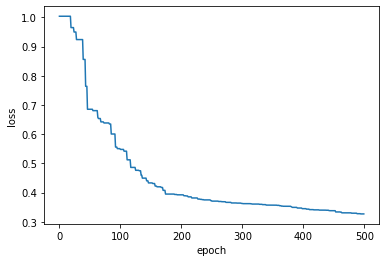

Text(0, 0.5, 'Te predi')

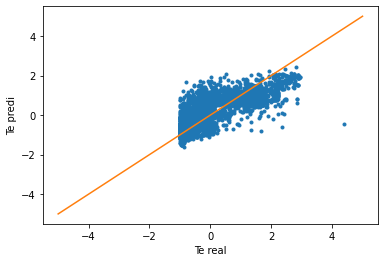

In [212]:
plt.plot([i for i in range(len(plotloss))],bestplotloss)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.plot(real,predi,'.')
plt.plot([-5,5],[-5,5])
plt.xlabel('Te real')
plt.ylabel('Te predi')

In [220]:
def train(dataloader, model, loss_fn, optimizer):

    size = len(dataloader.dataset)
    model.train() # Set the model to training mode
    for batch, (X, y) in enumerate(dataloader):
        #X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        pred = model(X) # Pass the data to the model to execute the model forward
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward() # Compute gradients of the loss w.r.t parameters (backward pass)
        optimizer.step() # Do a gradient descent step and adjust parameters
        optimizer.zero_grad() # Reset the gradients of model parameters to zero (gradients by default add up)

        if batch % 200 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() # Set the model to evaluation mode
    test_loss, correct = 0, 0
    with torch.no_grad(): # Do not track gradients while evaluating (faster)
        for X, y in dataloader:
            #X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item() # Compute CE loss on the batch
            #correct += (torch.abs(pred-y)<5).type(torch.float).sum().item() # Compute classification error
    test_loss /= num_batches
    #correct /= size
    print(f"Test Error: Avg loss: {test_loss:>8f} \n")

In [233]:
#solve with pytorch and classical nn
# Define model
model = nn.Sequential( # Ordered container of modules
    nn.Linear(81, 10), # Apply a linear transformation on the input using weights and biases
    nn.ReLU(), # Non-linear activation
    nn.Linear(10, 1)
).to(dtype=torch.float64)

#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss()

learning_rate = 4e-3
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # Pass model parameters to optimizer

epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}")
    train(training_loader, model, loss_fn, optimizer)
    test(validation_loader, model, loss_fn)

print("Done!")

Epoch 1
Test Error: Avg loss: 0.439813 

Epoch 2
Test Error: Avg loss: 0.376617 

Epoch 3
Test Error: Avg loss: 0.345599 

Epoch 4
Test Error: Avg loss: 0.325876 

Epoch 5
Test Error: Avg loss: 0.311852 

Epoch 6
Test Error: Avg loss: 0.300562 

Epoch 7
Test Error: Avg loss: 0.291345 

Epoch 8
Test Error: Avg loss: 0.284099 

Epoch 9
Test Error: Avg loss: 0.277855 

Epoch 10
Test Error: Avg loss: 0.273072 

Epoch 11
Test Error: Avg loss: 0.268914 

Epoch 12
Test Error: Avg loss: 0.265609 

Epoch 13
Test Error: Avg loss: 0.263299 

Epoch 14
Test Error: Avg loss: 0.260071 

Epoch 15
Test Error: Avg loss: 0.257623 

Epoch 16
Test Error: Avg loss: 0.255021 

Epoch 17
Test Error: Avg loss: 0.251983 

Epoch 18
Test Error: Avg loss: 0.250110 

Epoch 19
Test Error: Avg loss: 0.248749 

Epoch 20
Test Error: Avg loss: 0.246965 

Epoch 21
Test Error: Avg loss: 0.245648 

Epoch 22
Test Error: Avg loss: 0.244103 

Epoch 23
Test Error: Avg loss: 0.242954 

Epoch 24
Test Error: Avg loss: 0.241661 

E

In [234]:
size = len(validation_loader.dataset)
num_batches = len(validation_loader)
model.eval() # Set the model to evaluation mode
test_loss, correct = 0, 0
pred = []
real = []
with torch.no_grad(): # Do not track gradients while evaluating (faster)
    for X, y in validation_loader:
        #X, y = X.to(device), y.to(device)
        pred.append(model(X))
        real.append(y)

Text(0, 0.5, 'Te predi')

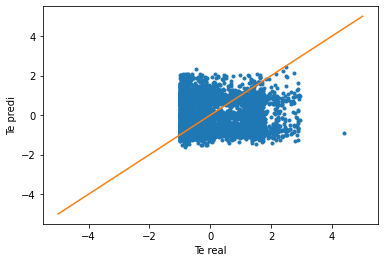

In [235]:
plt.plot(real,predi,'.')
plt.plot([-5,5],[-5,5])
plt.xlabel('Te real')
plt.ylabel('Te predi')